In [62]:
#!pip install --upgrade google-api-python-client

In [63]:
# import libraries and visualization packages
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
import numpy as np
from PIL import Image 
from IPython.display import JSON
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tenic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tenic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
# Set the API Key
api_key = '' # Key not shown here, please generate your own if you would like to implement this project

In [44]:
# Set Channel IDs to 10 of the youtube channels for Data Science content
channel_ids = ['UCV0qA-eDDICsRR9rPcnG7tw', #Joma
               'UCfzlCWGWYyIQ0aLC5w48gBQ', #Sentdex
               'UC4JX40jDee_tINbkjycV4Sg', #TechWithTim
               'UCCezIgC97PvUuR4_gbFUs5g', #CoreySchafer
               'UCNU_lfiiWBdtULKOw6X0Dig', #KrishNaik
               'UCtYLUTtgS3k1Fg4y5tAhLbw', #StatQuestwJohnStamer
               'UCFrjdcImgcQVyFbK04MBEhA', #BrandonFolz
               'UCEBpSZhI1X8WaP-kY_2LLcg', #365DataScience
               'UCV8e2g4IWQqK71bbzGDEI4Q', #DataProfessor
               'UCBPRJjIWfyNG4X-CRbnv78A', #AbhishekThakur
              ]

In [45]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [46]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [47]:
def get_video_ids(youtube, playlist_id):
    """
    Get video ids
    
    Params:
    ------
    youtube: build object of Youtube API
    playlist_ids: list of video IDs
    
    Returns:
    ------
    list with all videos within a playlist
    
    """    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [48]:
def get_video_details(youtube, video_ids):
    """
    Get video details
    
    Params:
    ------
    youtube: build object of Youtube API
    video_ids: list of video IDs
    
    Returns:
    ------
    dataframe with all video details for each video ID
    
    """
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [49]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [50]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,StatQuest with Josh Starmer,834000,43297841,226,UUtYLUTtgS3k1Fg4y5tAhLbw
1,Abhishek Thakur,77000,2091020,150,UUBPRJjIWfyNG4X-CRbnv78A
2,Krish Naik,686000,65551821,1578,UUNU_lfiiWBdtULKOw6X0Dig
3,sentdex,1180000,105898240,1231,UUfzlCWGWYyIQ0aLC5w48gBQ
4,Data Professor,139000,3725444,300,UUV8e2g4IWQqK71bbzGDEI4Q
5,365 Data Science,266000,11286785,214,UUEBpSZhI1X8WaP-kY_2LLcg
6,Joma Tech,2000000,156616498,105,UUV0qA-eDDICsRR9rPcnG7tw
7,Brandon Foltz,272000,24386809,279,UUFrjdcImgcQVyFbK04MBEhA
8,Tech With Tim,1110000,98111960,763,UU4JX40jDee_tINbkjycV4Sg
9,Corey Schafer,1010000,79783386,230,UUCezIgC97PvUuR4_gbFUs5g


In [51]:
# Get Playlist IDs
playlist_id_0 = "UUBPRJjIWfyNG4X-CRbnv78A" # Abhishek Thakur
playlist_id_1 = "UUEBpSZhI1X8WaP-kY_2LLcg" # 365 Data Science
playlist_id_2 = "UUV0qA-eDDICsRR9rPcnG7tw" # Joma Tech
playlist_id_3 = "UUFrjdcImgcQVyFbK04MBEhA" # Brandon Foltz
playlist_id_4 = "UUNU_lfiiWBdtULKOw6X0Dig" # Krish Naik
playlist_id_5 = "UU4JX40jDee_tINbkjycV4Sg" # Tech With Tim
playlist_id_6 = "UUtYLUTtgS3k1Fg4y5tAhLbw" # StatQuest with Josh Starmer
playlist_id_7 = "UUV8e2g4IWQqK71bbzGDEI4Q" # Data Professor
playlist_id_8 = "UUCezIgC97PvUuR4_gbFUs5g" # Corey Schafer
playlist_id_9 = "UUfzlCWGWYyIQ0aLC5w48gBQ" # sentdex

In [52]:
# Get video IDs
video_ids_A = get_video_ids(youtube, playlist_id_0)# Abhishek Thakur
video_ids_B = get_video_ids(youtube, playlist_id_1)# 365 Data Science
video_ids_C = get_video_ids(youtube, playlist_id_2)# Joma Tech
video_ids_D = get_video_ids(youtube, playlist_id_3)# Brandon Foltz
video_ids_E = get_video_ids(youtube, playlist_id_4)# Krish Naik
video_ids_F = get_video_ids(youtube, playlist_id_5)# Tech With Tim
video_ids_G = get_video_ids(youtube, playlist_id_6)# StatQuest with Josh Starmer
video_ids_H = get_video_ids(youtube, playlist_id_7)# Data Professor
video_ids_I = get_video_ids(youtube, playlist_id_8)# Corey Schafer
video_ids_J = get_video_ids(youtube, playlist_id_9)# sentdex

In [53]:
#Get video details
video_df_A = get_video_details(youtube, video_ids_A) 
video_df_B = get_video_details(youtube, video_ids_B) 
video_df_C = get_video_details(youtube, video_ids_C) 
video_df_D = get_video_details(youtube, video_ids_D) 
video_df_E = get_video_details(youtube, video_ids_E) 
video_df_F = get_video_details(youtube, video_ids_F) 
video_df_G = get_video_details(youtube, video_ids_G) 
video_df_H = get_video_details(youtube, video_ids_H)
video_df_I = get_video_details(youtube, video_ids_I)
video_df_J = get_video_details(youtube, video_ids_J)

video_df = pd.concat([video_df_A, video_df_B,video_df_C,video_df_D,video_df_E,video_df_F,video_df_G,video_df_H,video_df_I,video_df_J], axis=0)

In [54]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,izcmIemT-rU,Abhishek Thakur,TS-11: Transfer learning for time series,Notebook: https://www.kaggle.com/code/konradb/...,None,2022-10-12T15:59:28Z,2551,80,None,4,PT54M40S,hd,false
1,WOIURyGopJE,Abhishek Thakur,How to become a data scientist in 30 days?,How to become a data scientist in 30 days?\n.\...,"[machine learning, deep learning, artificial i...",2022-10-06T10:12:52Z,8665,221,None,82,PT10M42S,hd,false
2,47WeBiLV2Uo,Abhishek Thakur,TS-10: Validation methods for time series,Notebook: https://www.kaggle.com/code/konradb/...,None,2022-09-21T16:20:03Z,2897,103,None,1,PT1H14M,hd,false
3,NYZzBvKcfp4,Abhishek Thakur,TS-9: Hybrid methods for time series,Code: https://www.kaggle.com/code/konradb/ts-9...,None,2022-09-07T15:17:57Z,2203,90,None,1,PT42M44S,hd,false
4,7ZTarg4QYR4,Abhishek Thakur,TS-8: Hierarchical Time Series,Hierarchical structures are all around us: at ...,None,2022-07-28T15:34:27Z,2717,94,None,2,PT42M59S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,MGD_b2w_GU4,sentdex,How to Sort a Python Dictionary By Value or Key!,Sentdex.com\nFacebook.com/sentdex\nTwitter.com...,"[python dictionary, python dictionary sort, so...",2013-06-10T14:57:25Z,68030,488,None,37,PT7M26S,hd,true
1227,OyZkXsgv5qk,sentdex,Python's Logging Function,Sentdex.com\nFacebook.com/sentdex\nTwitter.com...,"[logging with python, python logging, python l...",2013-06-08T21:13:31Z,25199,150,None,18,PT14M19S,hd,false
1228,8PzDfykGg_g,sentdex,Python Encryption Tutorial with PyCrypto,Sentdex.com\nFacebook.com/sentdex\nTwitter.com...,"[sentdex, sentiment analysis, data mining, opi...",2013-05-24T18:05:43Z,110233,587,None,120,PT21M5S,sd,false
1229,wAwQ-noyB98,sentdex,Matplotlib Python Tutorial Part 1: Basics and ...,Sample code: http://pythonprogramming.net/matp...,"[sentdex, sentiment analysis, data mining, opi...",2013-05-16T21:24:52Z,173425,433,None,148,PT11M1S,hd,false


# Data Pre-processing


In [55]:
# Check Datatypes in Dataframe
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [56]:
!pip install isodate

In [57]:
# Convert Duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x : isodate.parse_duration(x))
video_df['duration_t'] = video_df['durationSecs'].astype('timedelta64[s]')

# Convert Duration to minutes
video_df['duration_m'] = video_df['durationSecs'].astype('timedelta64[s]')%60

# Compare Duration in minutes to original Duration object code
video_df[['duration_m', 'duration']] 

# Truncate the titles of videos to 25 characters
video_df['title'] = video_df['title'].str [:25] 

# Add tag count
video_df['tag_count'] = video_df['tags'].apply(lambda x:0 if x is None else len(x))

,duration_m,duration
0,40.0,PT54M40S
1,42.0,PT10M42S
2,0.0,PT1H14M
3,44.0,PT42M44S
4,59.0,PT42M59S
...,...,...
1226,26.0,PT7M26S
1227,19.0,PT14M19S
1228,5.0,PT21M5S
1229,1.0,PT11M1S


In [58]:
# Convert columns to numerical values
numeric_cols =['viewCount', 'likeCount', 'favouriteCount', 'duration_m','commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric,errors = 'coerce', axis = 1)

In [59]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,duration_m,tag_count
0,izcmIemT-rU,Abhishek Thakur,TS-11: Transfer learning,Notebook: https://www.kaggle.com/code/konradb/...,None,2022-10-12T15:59:28Z,2551.0,80.0,NaN,4.0,PT54M40S,hd,false,0 days 00:54:40,3280.0,40.0,0
1,WOIURyGopJE,Abhishek Thakur,How to become a data scie,How to become a data scientist in 30 days?\n.\...,"[machine learning, deep learning, artificial i...",2022-10-06T10:12:52Z,8665.0,221.0,NaN,82.0,PT10M42S,hd,false,0 days 00:10:42,642.0,42.0,5
2,47WeBiLV2Uo,Abhishek Thakur,TS-10: Validation methods,Notebook: https://www.kaggle.com/code/konradb/...,None,2022-09-21T16:20:03Z,2897.0,103.0,NaN,1.0,PT1H14M,hd,false,0 days 01:14:00,4440.0,0.0,0
3,NYZzBvKcfp4,Abhishek Thakur,TS-9: Hybrid methods for,Code: https://www.kaggle.com/code/konradb/ts-9...,None,2022-09-07T15:17:57Z,2203.0,90.0,NaN,1.0,PT42M44S,hd,false,0 days 00:42:44,2564.0,44.0,0
4,7ZTarg4QYR4,Abhishek Thakur,TS-8: Hierarchical Time S,Hierarchical structures are all around us: at ...,None,2022-07-28T15:34:27Z,2717.0,94.0,NaN,2.0,PT42M59S,hd,false,0 days 00:42:59,2579.0,59.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,MGD_b2w_GU4,sentdex,How to Sort a Python Dict,Sentdex.com\nFacebook.com/sentdex\nTwitter.com...,"[python dictionary, python dictionary sort, so...",2013-06-10T14:57:25Z,68030.0,488.0,NaN,37.0,PT7M26S,hd,true,0 days 00:07:26,446.0,26.0,18
1227,OyZkXsgv5qk,sentdex,Python's Logging Function,Sentdex.com\nFacebook.com/sentdex\nTwitter.com...,"[logging with python, python logging, python l...",2013-06-08T21:13:31Z,25199.0,150.0,NaN,18.0,PT14M19S,hd,false,0 days 00:14:19,859.0,19.0,21
1228,8PzDfykGg_g,sentdex,Python Encryption Tutoria,Sentdex.com\nFacebook.com/sentdex\nTwitter.com...,"[sentdex, sentiment analysis, data mining, opi...",2013-05-24T18:05:43Z,110233.0,587.0,NaN,120.0,PT21M5S,sd,false,0 days 00:21:05,1265.0,5.0,21
1229,wAwQ-noyB98,sentdex,Matplotlib Python Tutoria,Sample code: http://pythonprogramming.net/matp...,"[sentdex, sentiment analysis, data mining, opi...",2013-05-16T21:24:52Z,173425.0,433.0,NaN,148.0,PT11M1S,hd,false,0 days 00:11:01,661.0,1.0,16


In [60]:
video_df.dtypes

video_id                   object
channelTitle               object
title                      object
description                object
tags                       object
publishedAt                object
viewCount                 float64
likeCount                 float64
favouriteCount            float64
commentCount              float64
duration                   object
definition                 object
caption                    object
durationSecs      timedelta64[ns]
duration_t                float64
duration_m                float64
tag_count                   int64
dtype: object

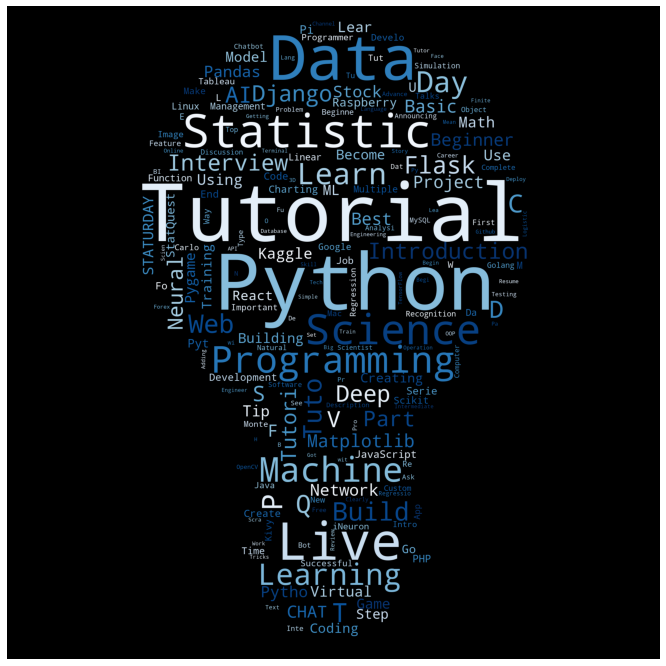

In [61]:
# Create a mask
mask = np.array(Image.open('Images/light-bulb-mask.png'))
          
# Create stopword list:    
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])
all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

# Generate a word cloud image
def plot_cloud(wordcloud):
    plt.figure(figsize=(14, 12))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 2000, random_state=1, background_color= 'black', 
                      colormap='Blues', collocations=False,mask = mask).generate(all_words_str)
# Display word cloud image
plot_cloud(wordcloud)

# Save word cloud image to file in current directory
cloud =  wordcloud.to_file('ds_wordcloud.png')